# MNIST手写体识别
MNIST手写体识别是图像识别中最经典的问题, 希望能够识别出人类手写的数字. 数据是65000张灰度图和对应的数字. 我们用之前的深度神经网络来尝试解决这个问题.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow.examples.tutorials.mnist.input_data as input_data

首先我们导入mnist数据集

In [3]:
mnist = input_data.read_data_sets('E:\\data\\MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting E:\data\MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting E:\data\MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting E:\data\MNIST_data\t10k-images-idx3-ubyte.gz
Extracting E:\data\MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


注意到read_data_sets的一个参数是one_hot<br>
这个数据集分成了两个部分: 训练和测试. 分开来是为了观察模型在完全没⻅过的数据上的表现, 从而体现泛化能力

In [4]:
train_set = mnist.train
test_set = mnist.test

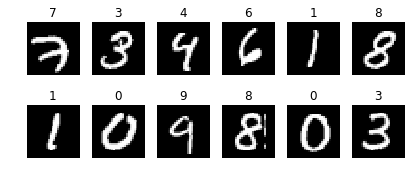

In [5]:
fig, axes = plt.subplots(ncols=6, nrows=2)
plt.tight_layout(w_pad=-2.0, h_pad=-10.0)

# 调用next_batch方法来一次性获取12个样本
# 这里有一个`shuffle`参数, 表达是否打乱样本间的顺序
images, labels = train_set.next_batch(12, shuffle=False)

for ind,(image, label) in enumerate(zip(images, labels)):
    # image 是一个 784 维的向量, 是图片进行拉伸产生的, 这里我们给它 reshape 回去
    image = image.reshape((28,28))
    
    # label 是一个 10 维的向量, 哪个下标处的值为1 说明是数字几
    label = label.argmax()
    
    row = ind // 6  
    col = ind % 6
    axes[row][col].imshow(image, cmap='gray')
    axes[row][col].axis('off')
    axes[row][col].set_title('%d'%label)
    

接下来定义深度网络结构

In [6]:
#定义隐藏层
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        # 注意这里的初始化方法是truncated_normal
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1),
                           shape=(input_depth,output_depth), name='weights')
        b = tf.get_variable(initializer=tf.constant_initializer(0.1),
                            shape=(output_depth), name='bias')
        net = tf.matmul(layer_input,w)+b
        return net
    
#定义网络结构
def DNN(x,output_depths, scope='DNN', reuse=None):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d'%(i+1), reuse=reuse)
        # 注意这里的激活函数
        net = tf.nn.relu(net)
        # 数字分为0, 1, ..., 9 所以这是10分类问题
        # 对应于 one_hot 的标签, 所以这里输出一个 10维的向量
    net = hidden_layer(net, 10, scope='classification', reuse=reuse)
    
    return net    

In [7]:
# 定义占位符
input_ph = tf.placeholder(dtype=tf.float32, shape=(None,784))
label_ph = tf.placeholder(dtype=tf.int64, shape=(None,10))

# 构造一个4层的神经网络, 它的隐藏节点数分别为: 400, 200, 100, 10
dnn = DNN(input_ph, [400, 200, 100])

In [8]:
# 这是一个分类问题, 因此我们采用交叉熵来计算损失函数
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)

# 下面定义的是正确率, 注意理解它为什么是这么定义的
accuracy = tf.reduce_mean(tf.cast(
                 tf.equal(tf.argmax(dnn, axis=-1), tf.argmax(label_ph, axis=-1)), 
                 dtype=tf.float32))

lr = 1e-2
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

In [9]:
sess = tf.InteractiveSession()

In [10]:
batch_size = 64
init = tf.global_variables_initializer()
sess.run(init)

for i in range(20000):
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(batch_size)
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    if (i+1)%1000 ==0:
        # 获取 batch_size 个测试样本
        test_imgs, test_labels = train_set.next_batch(batch_size)
        # 计算在当前样本上的训练以及测试样本的损失值和正确率
        loss_test, acc_test = sess.run([loss,accuracy], feed_dict={input_ph:test_imgs, label_ph:test_labels})
        print('Epoch %d  Train_loss %.4f  Test_accuracy %.3f'%(i+1, loss_test, acc_test))
print('\nTrain Finished!')

Epoch 1000  Train_loss 0.5131  Test_accuracy 0.875
Epoch 2000  Train_loss 0.2638  Test_accuracy 0.891
Epoch 3000  Train_loss 0.1911  Test_accuracy 0.938
Epoch 4000  Train_loss 0.1218  Test_accuracy 0.969
Epoch 5000  Train_loss 0.0736  Test_accuracy 1.000
Epoch 6000  Train_loss 0.0871  Test_accuracy 0.953
Epoch 7000  Train_loss 0.2009  Test_accuracy 0.906
Epoch 8000  Train_loss 0.1032  Test_accuracy 0.984
Epoch 9000  Train_loss 0.0481  Test_accuracy 0.984
Epoch 10000  Train_loss 0.0828  Test_accuracy 0.969
Epoch 11000  Train_loss 0.0897  Test_accuracy 0.969
Epoch 12000  Train_loss 0.1096  Test_accuracy 0.984
Epoch 13000  Train_loss 0.0355  Test_accuracy 1.000
Epoch 14000  Train_loss 0.0581  Test_accuracy 0.984
Epoch 15000  Train_loss 0.0444  Test_accuracy 1.000
Epoch 16000  Train_loss 0.0337  Test_accuracy 1.000
Epoch 17000  Train_loss 0.0374  Test_accuracy 0.984
Epoch 18000  Train_loss 0.0267  Test_accuracy 1.000
Epoch 19000  Train_loss 0.0289  Test_accuracy 1.000
Epoch 20000  Train_lo

In [11]:
# 计算所有训练样本的损失值以及正确率
train_loss = []
train_acc = []
batch_size = 64
for i in range(train_set.num_examples // batch_size):
    images, labels = train_set.next_batch(batch_size=batch_size)
    loss_train, acc_train = sess.run([loss, accuracy], 
                                     feed_dict={input_ph:images, label_ph:labels})
    train_loss.append(loss_train)
    train_acc.append(acc_train)
print('Train Loss:{:.4f}'.format(np.array(train_loss).mean()))
print('Train Accuracy:{:.3f}'.format(np.array(train_acc).mean()))

# 计算所有测试样本的损失值以及正确率
test_loss = []
test_acc = []
batch_size = 64
for i in range(test_set.num_examples // batch_size):
    images, labels = test_set.next_batch(batch_size=batch_size)
    loss_test, acc_test = sess.run([loss, accuracy], 
                                     feed_dict={input_ph:images, label_ph:labels})
    test_loss.append(loss_test)
    test_acc.append(acc_test)
print('\nTest Loss:{:.4f}'.format(np.array(test_loss).mean()))
print('Test Accuracy:{:.3f}'.format(np.array(test_acc).mean()))   

Train Loss:0.0508
Train Accuracy:0.986

Test Loss:0.0942
Test Accuracy:0.970


In [12]:
sess.close()

# Tensorboard & tf.summary
已经给大家分享过如何使用Tensorboard将我们构建的计算图显示出来, 这里我们还要介绍它和tf.summary结合起来体现的更加强大的功能: 可视化训练.首先介绍一下tf.summary, 它能够收集训练过程中的各种tensor的信息并把它保存起来以供Tensorboard读取并展示. 按照下面的方法来使用它

# 构造summary
- 如果你想收集表示一个标量或者一个数的tensor的信息, 比如上面的loss<br>
`loss_sum = tf.summary.scalar('loss', loss)`

上面的语句就会告诉Tensorflow, 在运行过程中, 我要让Tensorboard显示误差的变化了

- 如果你想收集一个tensor的分布情况, 这个tensor可以是任意形状, 比如我们定义了一个(784, 400)的权重w<br>`w_hist = tf.summary.histogram('w_hist', w)`

- 如果你想收集一个4维的1-通道(灰度图), 3-通道(RGB), 4-通道(RGBA)的tensor的变化, 比如我们输出了一个(1, 8, 8, 1)的灰度图image
<br> `image_sum = tf.summary.image('image', image)`

- 如果你想收集一个3维(batch, frame, channel), 2维(batch, frame)的变化, 比如我们输出了一个(10, 50,3)的tensor:audio<br>
`audio_sum = tf.summary.audio('audio', audio)`

在这次课程中, 我们暂时先使用scalar和histogram的summary, image和audio的summary将在之后的课程中介绍

In [13]:
# 重置计算图
# 调用此函数后使用任何以前创建的tf.Operation或tf.Tensor对象将导致未定义的行为
tf.reset_default_graph() 

# 重新定义占位符
input_ph = tf.placeholder(shape=(None,784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None,10), dtype=tf.int32)

现在, 我们需要重新构建前向神经网络, 为了简化代码, 我们在构造一个隐藏层以及它的参数的函数内部构造tf.summary

In [14]:
# 构造权重, 用`truncated_normal`初始化
def weight_variable(shape):
    init = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(init)

# 构造偏置, 用`0.1`初始化
def bias_variable(shape):
    init = tf.constant(0.1, shape=shape)
    return tf.Variable(init)

# 构造添加`variable`的`summary`的函数
def variable_summaries(var):
    with tf.name_scope('summaries'):
        # 计算平均值
        mean = tf.reduce_mean(var)
        # 将平均值添加到`summary`中, 这是一个数值, 所以我们用`tf.summary.scalar`
        tf.summary.scalar('mean', mean)
        
        # 计算标准差
        with tf.name_scope('sttdev'):
            sttdev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
            # 将标准差添加到`summary`中
            tf.summary.scalar('sttdev', sttdev)

        # 添加最大值,最小值`summary`
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))

        # 添加这个变量分布情况的`summary`, 我们希望观察它的分布, 所以用`tf.summary.histogram`
        tf.summary.histogram('histogram', var)

In [15]:
# 构造一个隐藏层
def hidden_layer(x, output_dim, scope='hidden_layer', act=tf.nn.relu, reuse=None):
    # 获取输入的‘depth’
    input_dim = x.get_shape().as_list()[-1]
    
    with tf.name_scope(scope):
        with tf.name_scope('weight'):
            # 构造`weight`
            weight = weight_variable([input_dim,output_dim])
            # 添加`weight`的`summary`
            variable_summaries(weight)
        with tf.name_scope('bias'):
            # 构造`bias`
            bias = bias_variable([output_dim])
            # 添加`bias`的`summary`
            variable_summaries(bias)
        
        with tf.name_scope('linear'):
            # 计算`xw+b`
            preact = tf.matmul(x,weight)+bias
            # 添加激活层之前输出的分布情况到`summary`
            tf.summary.histogram('pre_activation', preact)
        
        # 经过激活层`act`
        output = act(preact)
        # 添加激活后输出的分布情况到`summary`
        tf.summary.histogram('output',output)
        
        return output

In [16]:
# 构造深度神经网络
def DNN(x, output_depths, scope='DNN_with_sums', reuse=None):
    with tf.name_scope(scope):
        net = x
        for i, output_depth in enumerate(output_depths):
            net = hidden_layer(net, output_depth, scope='hidden%d'%(i+1),reuse=reuse)
        # 最后有一个分类层
        net = hidden_layer(net, 10, scope='classification',
                           act=tf.identity, reuse=reuse)
        return net
    
dnn_with_sums = DNN(input_ph, [400,200,100])

In [17]:
# 重新定义`loss`, `acc`, `train_op`
with tf.name_scope('cross_entropy'):
    loss = tf.losses.softmax_cross_entropy(logits=dnn_with_sums,
                                           onehot_labels=label_ph)
    tf.summary.scalar('cross_entropy', loss)

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn_with_sums,axis=-1),
                              tf.argmax(label_ph,axis=-1)),dtype=tf.float32))
    tf.summary.scalar('accuracy',accuracy)

with tf.name_scope('train'):
    lr = 1e-2
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss)

# (可选)融合summary
- 我们可以把前面定义的所有summary都融合成一个summary<br>
`merged = tf.summary.merge_all`
- 也可以只是融合某些summary<br>
`merged = tf.summary.merge([loss_sum, image_sum])`

In [18]:
merged = tf.summary.merge_all()

In [19]:
sess = tf.InteractiveSession()

# 输出summary
summary是需要导出到外部文件的
- 首先定义一个文件读写器<br>
`summary_weiter = tf.summary.FileWriter('graph/summaries', sess.graph)`
- 然后在训练的过程中, 在你希望的时候运行一次merged或者是你之前自己定义的某个通过summary定义的op<br>
`summaries = sess.run(merged, feed_dict={...})`
- 然后将这个summaries写入到summari_writer内,注意step表示你当前训练的步数, 当然你也可以设定为其他你想要用的数值<br>
`summary_writer.add_summary(summaries, step)`
- 最后关闭文件读写器<br>
`summary_writer.close()`

In [20]:
train_writer = tf.summary.FileWriter('graph/train', sess.graph)
test_writer = tf.summary.FileWriter('graph/test', sess.graph)

batch_size = 64
sess.run(tf.global_variables_initializer())

for i in range(20000):
    images, labels = train_set.next_batch(batch_size=batch_size)
    sess.run(train_op, feed_dict={input_ph:images, label_ph:labels})
    if (i+1)%1000==0:
        test_images, test_labels = test_set.next_batch(batch_size=batch_size)
        # 获取`train`数据的`summaries`以及`loss`, `acc`信息
        sum_train, loss_train, acc_train = sess.run([merged, loss, accuracy], 
                    feed_dict={input_ph:images, label_ph:labels})
        # 将`train`的`summaries`写入到`train_writer`中
        train_writer.add_summary(sum_train,i)
        # 获取`test`数据的`summaries`以及`loss`, `acc`信息
        sum_test, loss_test, acc_test = sess.run([merged, loss, accuracy], 
                    feed_dict={input_ph:test_images, label_ph:test_labels})
        # 将`test`的`summaries`写入到`test_writer`中
        test_writer.add_summary(sum_test,i)
        print('Epoch %d   Train_loss %.4f   Train_acc %.3f\n             Test_loss %.4f    Test_acc %.3f\n'%(i+1,
                          loss_train, acc_train, loss_test, acc_test))
train_writer.close()
test_writer.close()
print('Train Done!')

Epoch 1000   Train_loss 0.3608   Train_acc 0.891
             Test_loss 0.3398    Test_acc 0.922

Epoch 2000   Train_loss 0.1051   Train_acc 0.969
             Test_loss 0.0975    Test_acc 0.969

Epoch 3000   Train_loss 0.1305   Train_acc 0.984
             Test_loss 0.2682    Test_acc 0.938

Epoch 4000   Train_loss 0.1280   Train_acc 0.953
             Test_loss 0.1472    Test_acc 0.953

Epoch 5000   Train_loss 0.1943   Train_acc 0.969
             Test_loss 0.1888    Test_acc 0.953

Epoch 6000   Train_loss 0.0442   Train_acc 1.000
             Test_loss 0.0521    Test_acc 1.000

Epoch 7000   Train_loss 0.0711   Train_acc 0.984
             Test_loss 0.0906    Test_acc 0.984

Epoch 8000   Train_loss 0.0992   Train_acc 0.984
             Test_loss 0.2433    Test_acc 0.938

Epoch 9000   Train_loss 0.0317   Train_acc 1.000
             Test_loss 0.1097    Test_acc 0.969

Epoch 10000   Train_loss 0.0521   Train_acc 0.984
             Test_loss 0.1738    Test_acc 0.938

Epoch 11000   Train

In [21]:
# 计算所有训练样本的损失值以及正确率
train_loss = []
train_acc = []
batch_size = 64
for i in range(train_set.num_examples // batch_size):
    images, labels = train_set.next_batch(batch_size)
    loss_train, acc_train = sess.run([loss,accuracy],
                                     feed_dict={input_ph:images, label_ph:labels})
    train_loss.append(loss_train)
    train_acc.append(acc_train)
    
print('Train Loss {:.4f}   Acurracy {:.3f}'.format((np.array(train_loss).mean()),
                                         np.array(train_acc).mean()))

# 计算所有测试样本的损失值以及正确率
test_loss = []
test_acc = []
batch_size = 64
for i in range(test_set.num_examples // batch_size):
    images, labels = test_set.next_batch(batch_size)
    loss_test, acc_test = sess.run([loss,accuracy],
                                     feed_dict={input_ph:images, label_ph:labels})
    test_loss.append(loss_test)
    test_acc.append(acc_test)
    
print('Test Loss {:.4f}   Acurracy {:.3f}'.format((np.array(test_loss).mean()),
                                         np.array(test_acc).mean()))

Train Loss 0.0458   Acurracy 0.987
Test Loss 0.0949   Acurracy 0.973


# 打开Tensorboard
在之前对计算图可视化的时候, 我们用tensorboard --logdir=.命令打开过Tensorboard显示当前目录下`.但Tensorboard支持打开多个目录下的.events`文件, 方便我们对比不同模型或者训练和测试之间的差别在test_summary目录中输入以下命令<br>
`$ tensorboard --logdir=train:train/,test:test/`